In [1]:
import wntr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [2]:
cmap=plt.get_cmap('viridis')

In [3]:
inp_file='Net3.inp'

In [4]:
wn=wntr.network.WaterNetworkModel(inp_file)

In [5]:
wn.options.time.duration=48*3600
wn.options.time.hydraulic_timestep=1800
wn.options.time.report_timestep=1800
wn.options.hydraulic.required_pressure=15
wn.options.hydraulic.minimum_pressure=0

In [6]:
pipe_diameters=wn.query_link_attribute('diameter',np.less_equal,0.9144,link_type=wntr.network.Pipe)

In [7]:
pipe_diameters

60     0.6096
101    0.4572
103    0.4064
105    0.3048
107    0.3048
        ...  
323    0.3048
325    0.2032
329    0.7620
330    0.7620
333    0.7620
Length: 114, dtype: float64

In [8]:
failureProbability=pipe_diameters/pipe_diameters.sum()

In [9]:
failureProbability

60     0.014440
101    0.010830
103    0.009627
105    0.007220
107    0.007220
         ...   
323    0.007220
325    0.004813
329    0.018051
330    0.018051
333    0.018051
Length: 114, dtype: float64

In [10]:
f=open('wn.pickle','wb')
pickle.dump(wn,f)

In [11]:
f.close()

In [12]:
results={}
np.random.seed(67823)

In [13]:
for i in range(5):
    N=np.random.randint(1,5+1)
    pipestoFail=np.random.choice(failureProbability.index,5,replace=False,p=failureProbability.values)
    timeOFfailure=np.round(np.random.uniform(1,10,1)[0],2)
    durationOFfailure=np.round(np.random.uniform(12,24,1)[0],2)
    totaltime=timeOFfailure+durationOFfailure
    for id,singlepipetofail in enumerate(pipestoFail):
        pipe=wn.get_link(singlepipetofail)
        leakdiameter=pipe.diameter*0.3
        leakArea=3.14159*(leakdiameter/2)**2
        new_pipe_name=f"B2_{i}_{id}"
        new_junction_name=f"leaknode_{i}_{id}"
        wn=wntr.morph.split_pipe(wn,singlepipetofail,new_pipe_name,new_junction_name)
        leak_node=wn.get_node(new_junction_name)
        leak_node.add_leak(wn,area=leakArea,start_time=timeOFfailure*3600,end_time=totaltime*3600)
    wn.options.hydraulic.demand_model='PDD'
    sim=wntr.sim.WNTRSimulator(wn)
    print('Pipe breaks: '+str(pipestoFail)+ 'Start Time: '+ str(timeOFfailure)+ ' End Time:'+ str(totaltime))
    results[i]=sim.run_sim()
    f=open('wn.pickle','rb')
    wn=pickle.load(f)
    f.close()

Pipe breaks: ['137' '311' '60' '175' '179']Start Time: 5.6 End Time:28.159999999999997
Pipe breaks: ['121' '161' '239' '193' '191']Start Time: 7.01 End Time:25.79
Pipe breaks: ['191' '131' '249' '211' '193']Start Time: 9.85 End Time:23.310000000000002
Pipe breaks: ['281' '179' '309' '240' '277']Start Time: 5.72 End Time:21.63
Pipe breaks: ['287' '238' '245' '131' '319']Start Time: 8.67 End Time:23.11


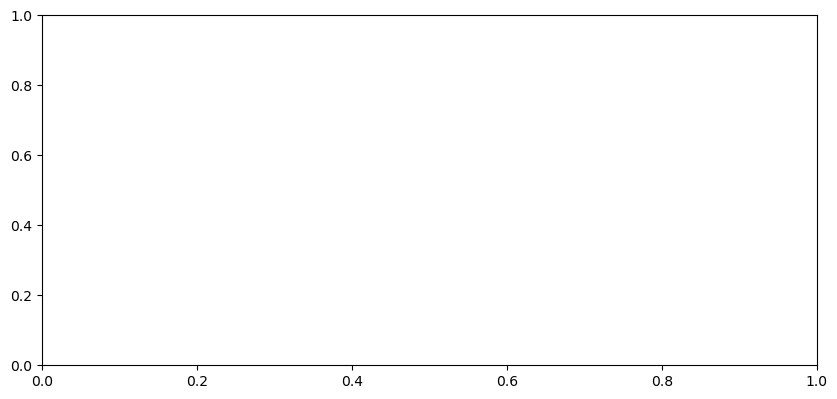

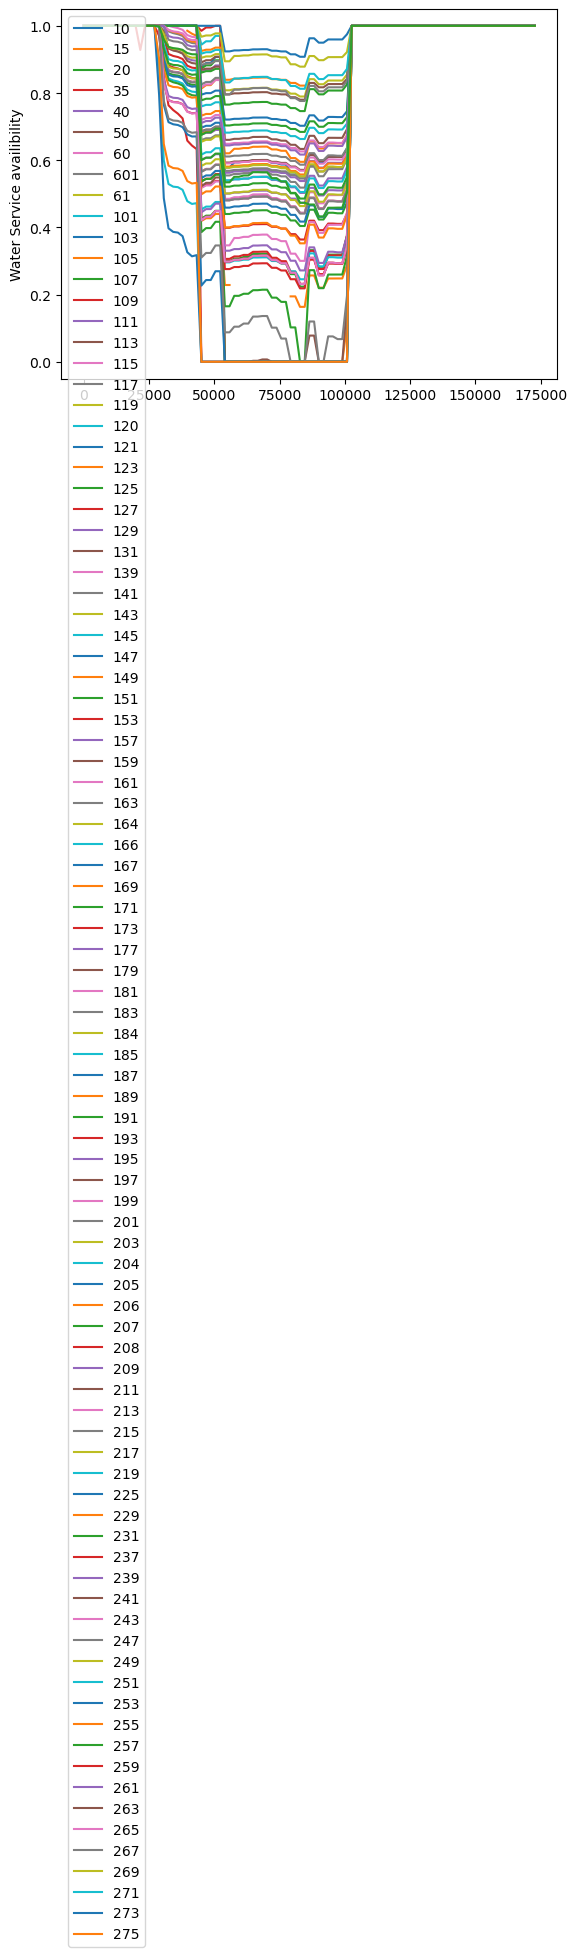

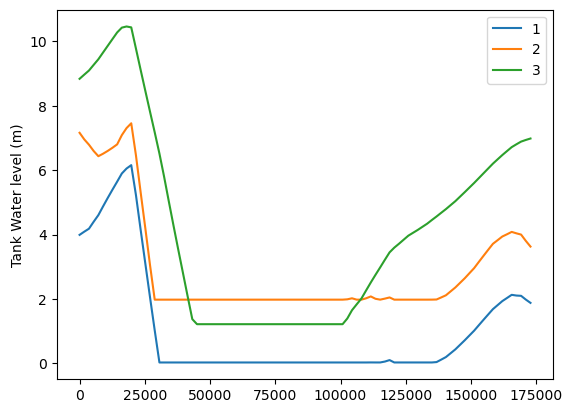

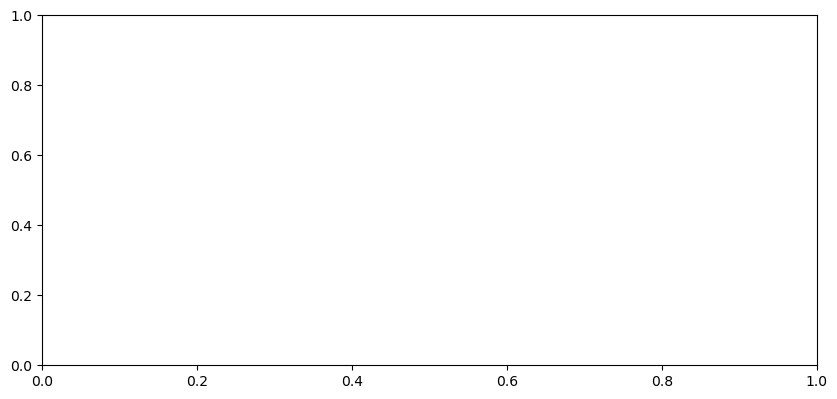

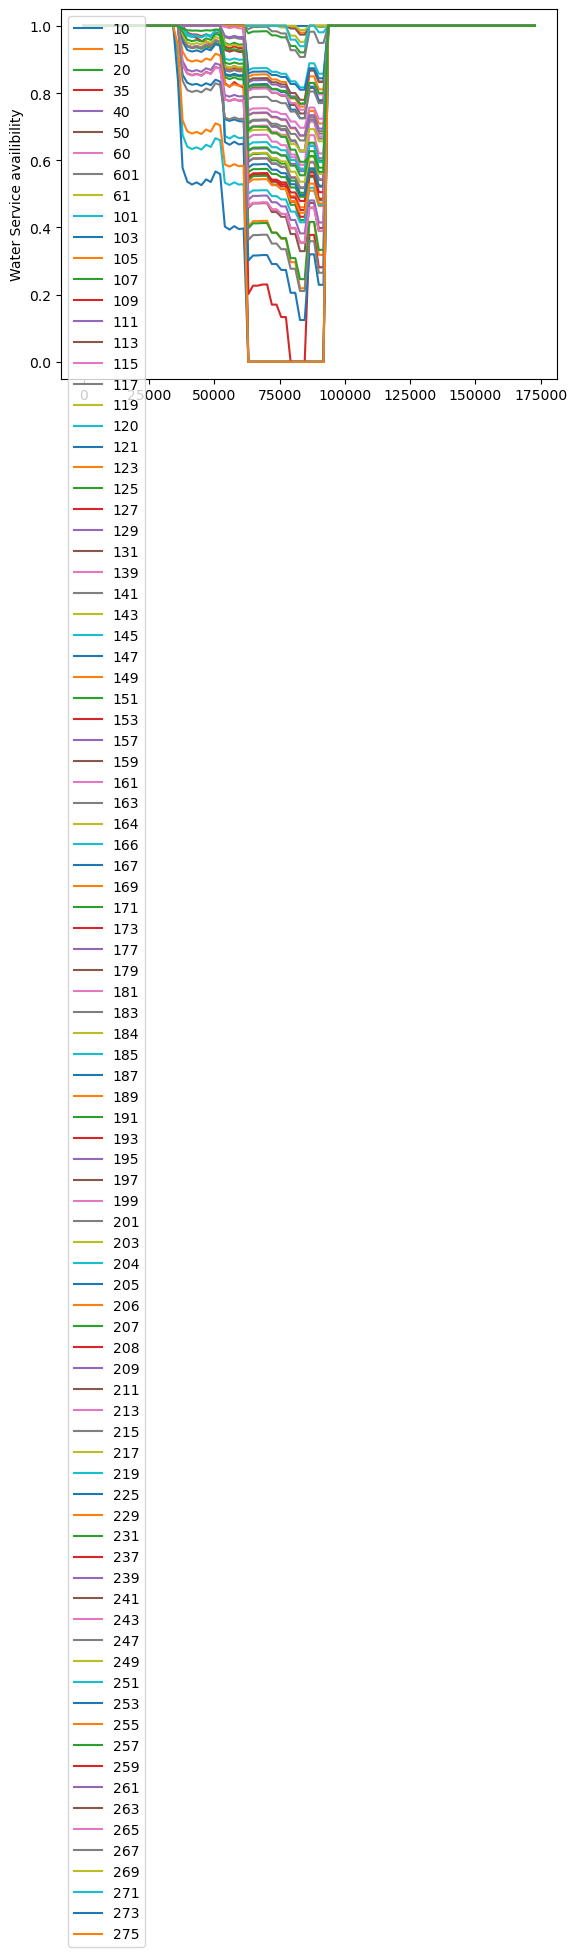

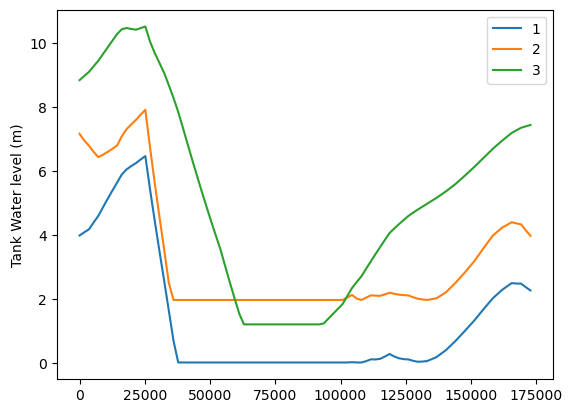

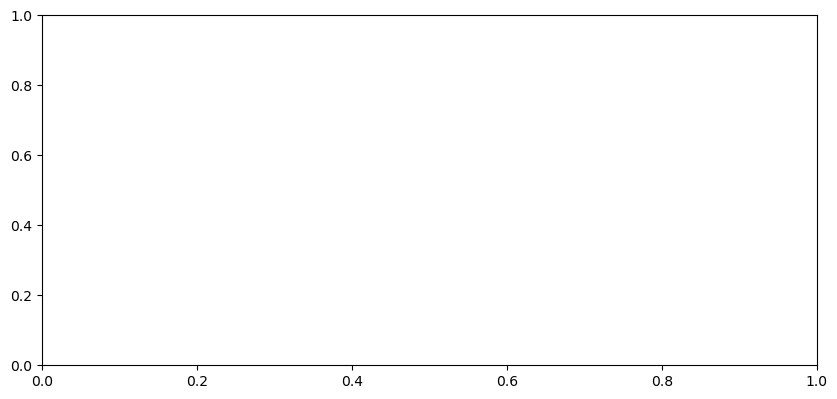

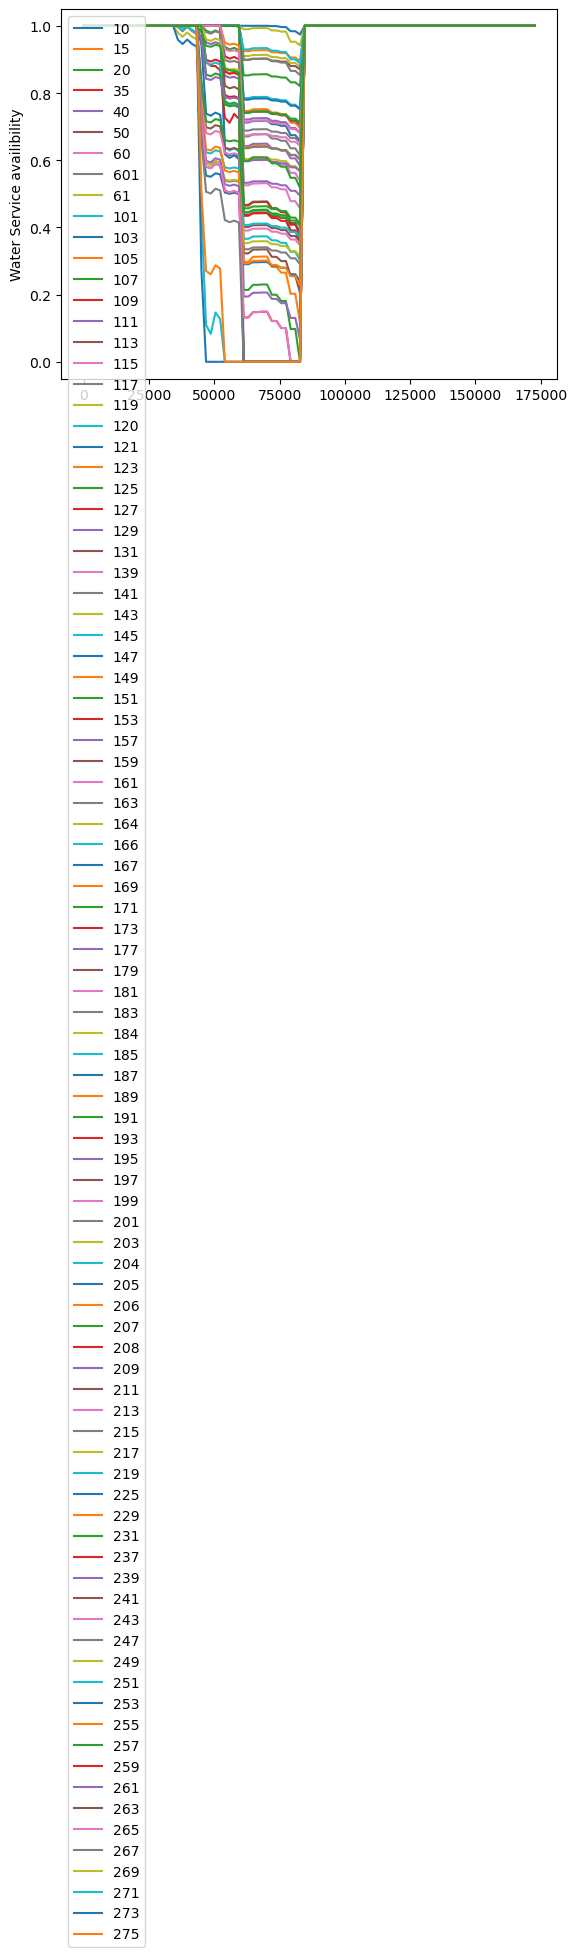

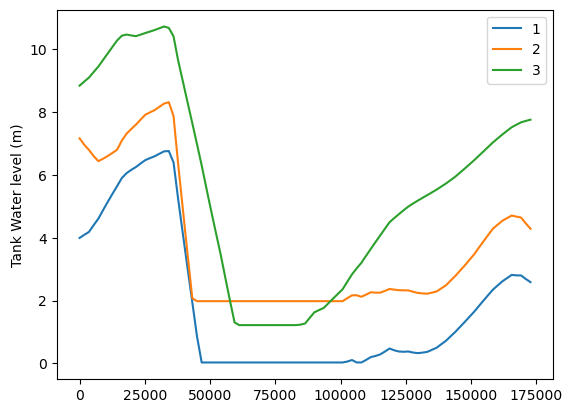

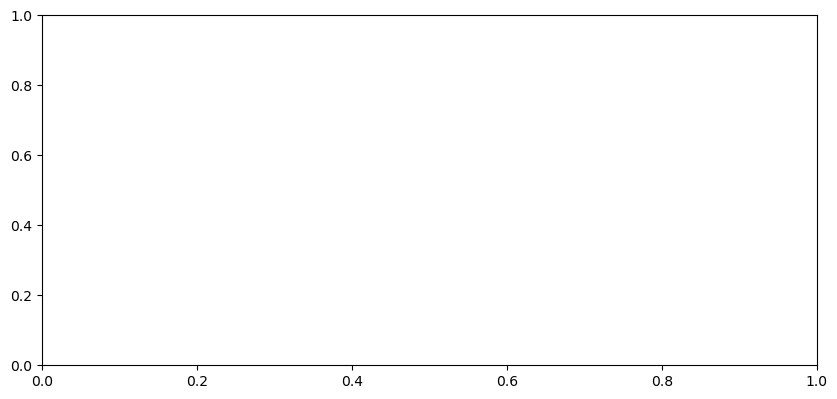

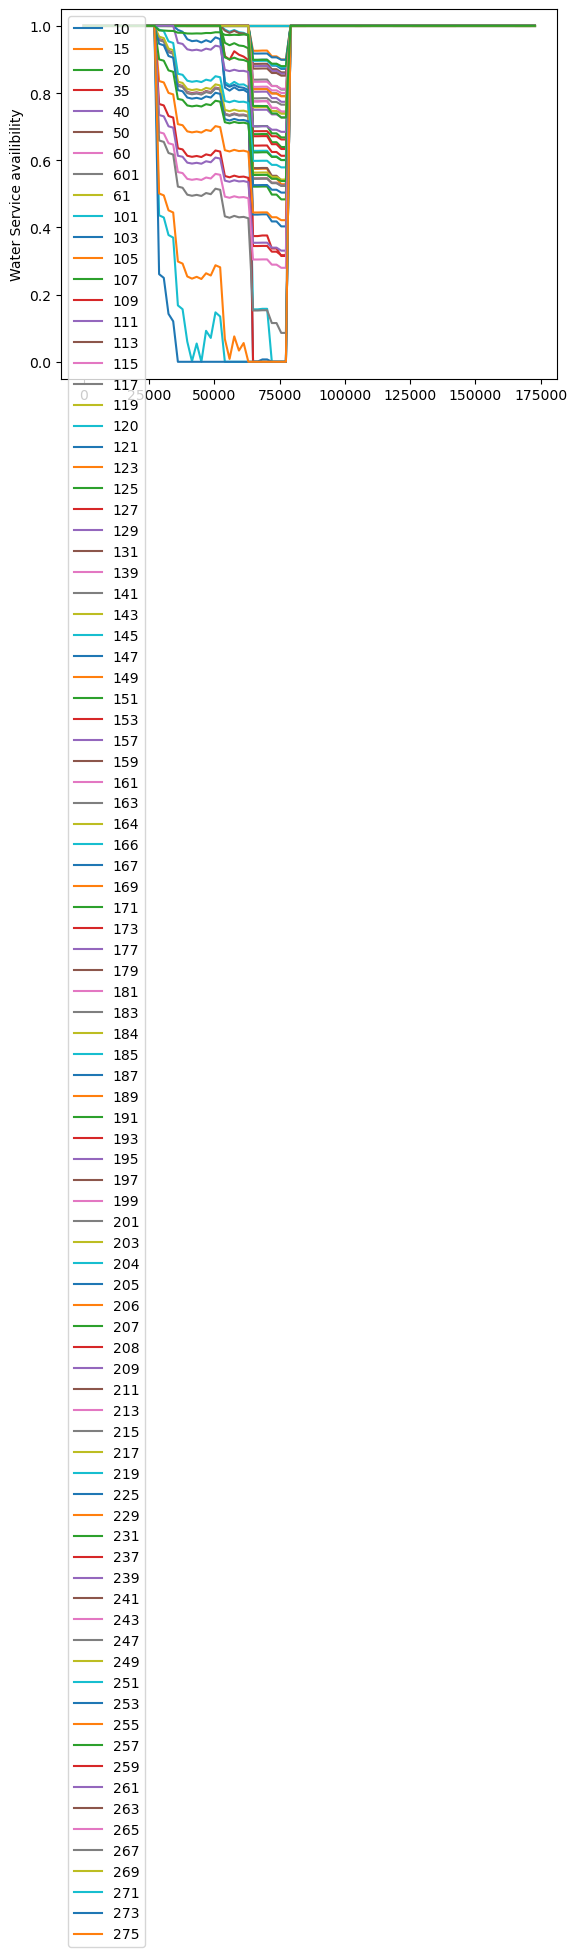

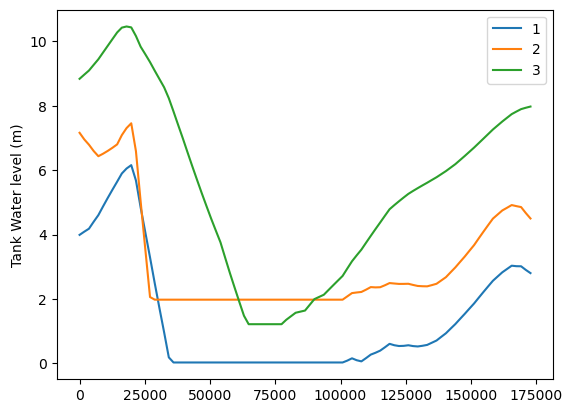

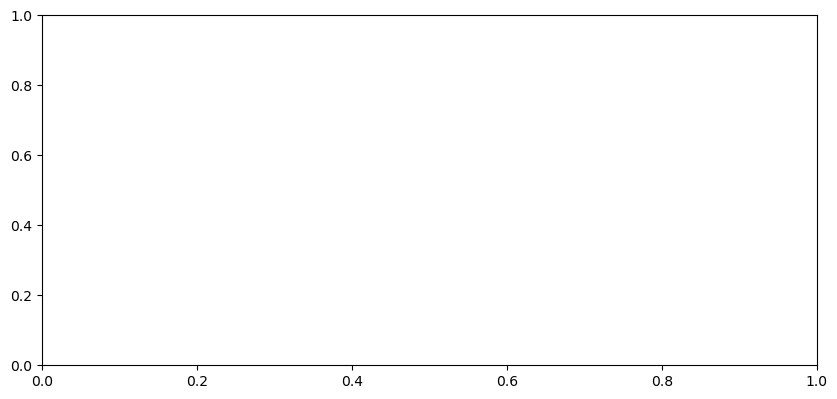

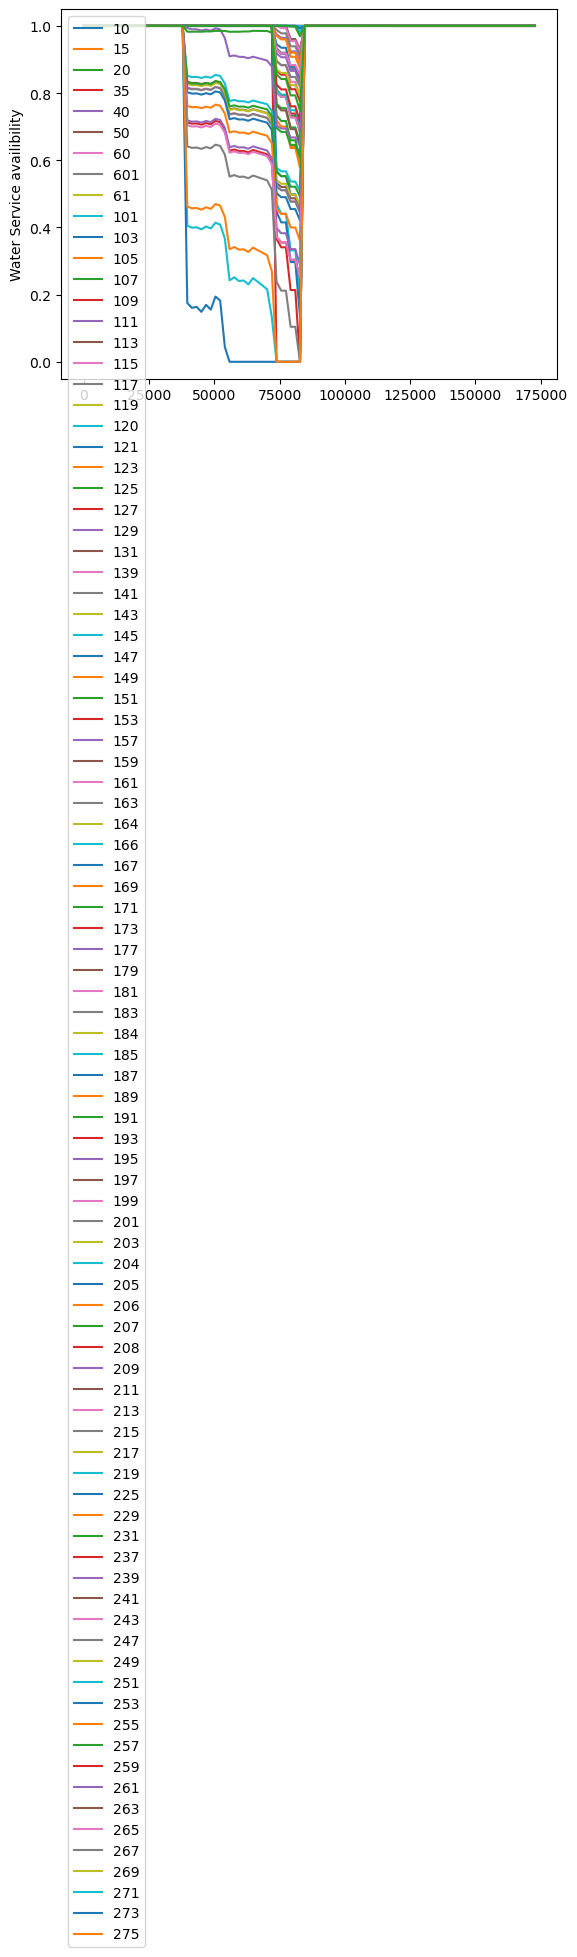

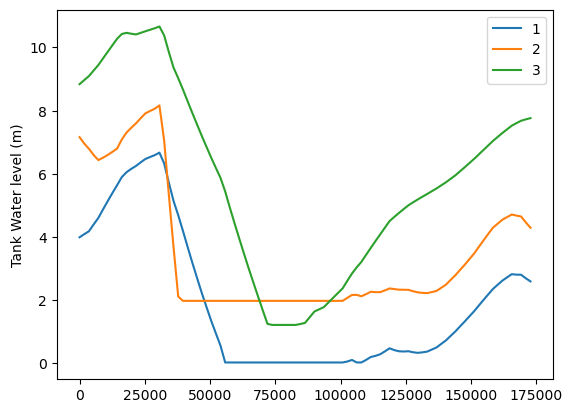

In [17]:

for i in results.keys():
    expected_demand=wntr.metrics.expected_demand(wn)
    demand=results[i].node['demand'].loc[:,wn.junction_name_list]
    waterserviceavail=wntr.metrics.water_service_availability(expected_demand,demand)

    waterserviceavail_av=wntr.metrics.water_service_availability(expected_demand.sum(axis=1),demand.sum(axis=1))

    tank_level=results[i].node['pressure'].loc[:,wn.tank_name_list]

    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    waterserviceavail.plot()
    waterserviceavail_av.plot()
    plt.ylabel('Water Service availibility')
    # Comment in to show water service avali visualization
    plt.subplot()
    tank_level.plot()
    plt.ylabel('Tank Water level (m)')
    